In [0]:

# load and prepare
from pandas import read_csv
from matplotlib import pyplot
from numpy import array
from numpy import hstack
from numpy import savetxt
from google.colab import files
uploaded = files.upload()

Saving eighthr.data to eighthr (2).data


In [0]:
# load dataset
data = read_csv('eighthr.data', header=None, index_col=0, parse_dates=True, squeeze=True)
print(data.shape)
# summarize class counts
counts = data.groupby(73).size()
for i in range(len(counts)):
	percent = counts[i] / data.shape[0] * 100
	print('Class=%d, total=%d, percentage=%.3f' % (i, counts[i], percent))


(2534, 73)
Class=0, total=2374, percentage=93.686
Class=1, total=160, percentage=6.314


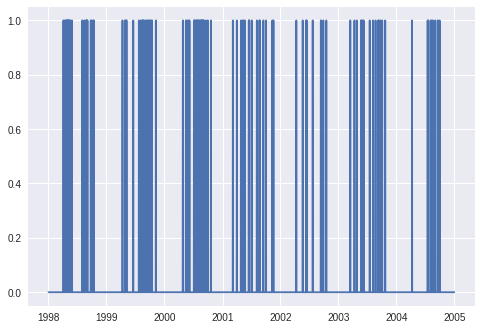

In [0]:
pyplot.plot(data.index, data.values[:,-1])
pyplot.show()

In [0]:
import numpy
values = data.values
# replace missing observations with 0
values[values=='?'] = 0.0
# frame as supervised learning
supervised = list()
for i in range(len(values) - 1):
	X, y = values[i, :-1], values[i + 1, -1]
	row = hstack((X,y))
	supervised.append(row)
supervised = array(supervised)
# split into train-test
split = 365 * 2
train, test = supervised[:-split,:], supervised[-split:,:]
train, test = train.astype('float32'), test.astype('float32')
print(train.shape, test.shape)
# save prepared datasets
savetxt('train.csv', train, delimiter=',')
savetxt('test.csv', test, delimiter=',')
# load datasets
train = numpy.loadtxt('train.csv', delimiter=',')
test = numpy.loadtxt('test.csv', delimiter=',')
# estimate naive probabilistic forecast
naive = sum(train[:,-1]) / train.shape[0]

(1803, 73) (730, 73)


In [0]:
yhat = [naive for _ in range(len(test))]


# naive prediction method
from sklearn.metrics import brier_score_loss
from numpy import loadtxt
# load datasets
train = loadtxt('train.csv', delimiter=',')
test = loadtxt('test.csv', delimiter=',')
naive = sum(train[:,-1]) / train.shape[0]
print(naive)
yhat = [naive for _ in range(len(test))]
testy = test[:, -1]
bs = brier_score_loss(testy, yhat)
print('Brier Score: %.6f' % bs)
bs_ref = bs
bss = (bs - bs_ref) / (0 - bs_ref)
print('Brier Skill Score: %.6f' % bss)
accuracy = getAccuracy(test, yhat)
print('Accuracy: {0}').format(accuracy)

NameError: ignored

In [0]:
#

# evaluate ensemble tree methods
from numpy import loadtxt
from numpy import mean
from matplotlib import pyplot
from sklearn.base import clone
from sklearn.metrics import brier_score_loss
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


def evaluate_once(bs_ref, template, trainX, trainy, testX, testy):
	model = clone(template)
	model.fit(trainX, trainy)
	probs = model.predict_proba(testX)
	yhat = probs[:, 1]
	bs = brier_score_loss(testy, yhat)
	bss = (bs - bs_ref) / (0 - bs_ref)
	return bss

# evaluate an sklearn model n times
def evaluate(bs_ref, model, trainX, trainy, testX, testy, n=10):
	scores = [evaluate_once(bs_ref, model, trainX, trainy, testX, testy) for _ in range(n)]
	print('>%s, bss=%.6f' % (type(model), mean(scores)))
	return scores

# load datasets
train = loadtxt('train.csv', delimiter=',')
test = loadtxt('test.csv', delimiter=',')
# split into inputs/outputs
trainX, trainy, testX, testy = train[:,:-1],train[:,-1],test[:,:-1],test[:,-1]
# estimate naive probabilistic forecast
naive = sum(train[:,-1]) / train.shape[0]
# forecast the test dataset
yhat = [naive for _ in range(len(test))]
# calculate naive bs
bs_ref = brier_score_loss(testy, yhat)
# evaluate a suite of ensemble tree methods
scores, names = list(), list()
n_trees=100
# bagging
model = BaggingClassifier(n_estimators=n_trees)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('bagging')
# extra
model = ExtraTreesClassifier(n_estimators=n_trees)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('extra')
# gbm
model = GradientBoostingClassifier(n_estimators=n_trees)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('gbm')
# rf
model = RandomForestClassifier(n_estimators=n_trees)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('rf')
# plot results
pyplot.boxplot(scores, labels=names)
pyplot.show()
